In [ ]:
! pip install yfinance -q
!pip install pygal -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.4 MB/s eta 0:00:00


In [22]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt


selected_tickers = ['NVDA', 'AAPL', 'AMZN', 'META', 'GOOGL']
start_date = "2013-01-01"
end_date   = "2023-01-01"


data = yf.download(selected_tickers, start=start_date, end=end_date, progress=False)
if isinstance(data.columns, pd.MultiIndex):
    if "Adj Close" in data.columns.get_level_values(0):
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]
else:
    if "Adj Close" in data.columns:
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]

stock_returns = stock_prices.pct_change().dropna()


ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]

example_index = ff.index[0]
if '-' in str(example_index):
    ff.index = pd.to_datetime(ff.index.astype(str), format="%Y-%m")
else:
    ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")

ff_daily = ff.resample('D').ffill()

ff_daily = ff_daily.loc[ff_daily.index >= pd.to_datetime(start_date)]

ff_daily.columns = ff_daily.columns.str.replace('-', '_')

ff_daily[['Mkt_RF', 'SMB', 'HML', 'RF']] = ff_daily[['Mkt_RF', 'SMB', 'HML', 'RF']] / 100

# ---------------------------
# Compute Multifactor Expected Returns for Each Stock
# ---------------------------
expected_returns = {}
for ticker in selected_tickers:
    df = pd.concat([stock_returns[ticker], ff_daily], axis=1).dropna()
    df.columns = ['stock_return', 'Mkt_RF', 'SMB', 'HML', 'RF']
    df['excess_return'] = df['stock_return'] - df['RF']

    X = df[['Mkt_RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    y = df['excess_return']
    model = sm.OLS(y, X).fit()

    # Average daily factor returns over the period
    avg_factors = ff_daily[['Mkt_RF', 'SMB', 'HML']].mean()
    expected_daily_excess = (model.params['const'] +
                             model.params['Mkt_RF'] * avg_factors['Mkt_RF'] +
                             model.params['SMB'] * avg_factors['SMB'] +
                             model.params['HML'] * avg_factors['HML'])
    annual_expected_excess = expected_daily_excess * 252
    annual_rf = ff_daily['RF'].mean() * 252
    expected_returns[ticker] = annual_rf + annual_expected_excess

# ---------------------------
# Compute Historical Covariance Matrix (Annualized)
# ---------------------------
cov_matrix = stock_returns[selected_tickers].cov() * 252

# ---------------------------
# MPT Simulation using Multifactor Expected Returns (with min weight constraint)
# ---------------------------
num_portfolios = 15000  # Number of simulated portfolios
results = np.zeros((3, num_portfolios))  # Rows: [Portfolio Return, Portfolio Volatility, Sharpe Ratio]
weights_record = []
multi_expected_returns = np.array([expected_returns[ticker] for ticker in selected_tickers])
risk_free_rate_annual = ff_daily['RF'].mean() * 252

n = len(selected_tickers)
min_weight = 0.05  # Minimum weight per stock

for i in range(num_portfolios):
    # Generate weights that sum to 1 with each weight >= 0.05 using a Dirichlet-based method
    weights = min_weight + np.random.dirichlet(np.ones(n)) * (1 - n * min_weight)
    weights_record.append(weights)

    port_return = np.dot(weights, multi_expected_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate_annual) / port_vol

    results[0, i] = port_return
    results[1, i] = port_vol
    results[2, i] = sharpe_ratio

results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio'])
max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = results_df.iloc[max_sharpe_idx]
optimal_weights = weights_record[max_sharpe_idx]

print("\nOptimal Portfolio using Multifactor Expected Returns (MPT):")
print(max_sharpe_portfolio)
optimal_weights_df = pd.DataFrame({'Ticker': selected_tickers, 'Weight (%)': optimal_weights*100})
print("\nOptimal Weights (each >= 5%):")
print(optimal_weights_df)

# ---------------------------
# Compare with Custom Weightings
# ---------------------------
# Define your custom weightings here (ensure they sum to 1)
custom_weights = {
    'NVDA': 0.20,  # Replace with your custom weight for NVDA
    'AAPL': 0.10,  # Replace with your custom weight for AAPL
    'AMZN': 0.23,  # Replace with your custom weight for AMZN
    'META': 0.28,  # Replace with your custom weight for META
    'GOOGL': 0.19  # Replace with your custom weight for GOOGL
}
# Convert custom weights to an array in the same order as selected_tickers
custom_weights_array = np.array([custom_weights[ticker] for ticker in selected_tickers])

def portfolio_performance(weights, expected_returns_array, cov_matrix, risk_free_rate):
    port_return = np.dot(weights, expected_returns_array)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_vol
    return port_return, port_vol, sharpe_ratio

custom_port_return, custom_port_vol, custom_sharpe = portfolio_performance(custom_weights_array, multi_expected_returns, cov_matrix, risk_free_rate_annual)

print("\nCustom Portfolio Performance:")
print(f"  Expected Return: {custom_port_return:.2%}")
print(f"  Volatility: {custom_port_vol:.2%}")
print(f"  Sharpe Ratio: {custom_sharpe:.2f}")


<ipython-input-22-523c3846df4f>:35: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]
<ipython-input-22-523c3846df4f>:35: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]



Optimal Portfolio using Multifactor Expected Returns (MPT):
Return          0.410765
Volatility      0.364510
Sharpe Ratio    0.731549
Name: 1211, dtype: float64

Optimal Weights (each >= 5%):
  Ticker  Weight (%)
0   NVDA   70.516487
1   AAPL    9.034646
2   AMZN    6.538917
3   META    7.294350
4  GOOGL    6.615599

Custom Portfolio Performance:
  Expected Return: 27.55%
  Volatility: 28.02%
  Sharpe Ratio: 0.47


##Virtual fund

In [12]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# Parameters and Data Download
# ---------------------------
selected_tickers = ['NVDA', 'AAPL', 'AMZN', 'GOOGL','NFLX','^GSPC','SHOP','TSLA','MSFT']
start_date = "2013-01-01"  # 10-year lookback period ending 2022-12-31
end_date   = "2023-01-01"

# Download stock data from yfinance
data = yf.download(selected_tickers, start=start_date, end=end_date, progress=False)
if isinstance(data.columns, pd.MultiIndex):
    if "Adj Close" in data.columns.get_level_values(0):
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]
else:
    if "Adj Close" in data.columns:
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]

# Compute daily returns
stock_returns = stock_prices.pct_change().dropna()

# ---------------------------
# Fetch Fama–French 3-Factor Data via pandas_datareader
# ---------------------------
ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]
# Determine correct format based on the index string pattern
example_index = ff.index[0]
if '-' in str(example_index):
    ff.index = pd.to_datetime(ff.index.astype(str), format="%Y-%m")
else:
    ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")
# Resample monthly data to daily frequency using forward fill
ff_daily = ff.resample('D').ffill()
# Restrict factor data to the period of our stock returns
ff_daily = ff_daily.loc[ff_daily.index >= pd.to_datetime(start_date)]
# Rename columns: replace '-' with '_' (e.g., "Mkt-RF" becomes "Mkt_RF")
ff_daily.columns = ff_daily.columns.str.replace('-', '_')
# Convert factor values from percentages to decimals
ff_daily[['Mkt_RF', 'SMB', 'HML', 'RF']] = ff_daily[['Mkt_RF', 'SMB', 'HML', 'RF']] / 100

# ---------------------------
# Compute Multifactor Expected Returns for Each Stock
# ---------------------------
expected_returns = {}
for ticker in selected_tickers:
    df = pd.concat([stock_returns[ticker], ff_daily], axis=1).dropna()
    df.columns = ['stock_return', 'Mkt_RF', 'SMB', 'HML', 'RF']
    df['excess_return'] = df['stock_return'] - df['RF']

    X = df[['Mkt_RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    y = df['excess_return']
    model = sm.OLS(y, X).fit()

    # Average daily factor returns over the period
    avg_factors = ff_daily[['Mkt_RF', 'SMB', 'HML']].mean()
    expected_daily_excess = (model.params['const'] +
                             model.params['Mkt_RF'] * avg_factors['Mkt_RF'] +
                             model.params['SMB'] * avg_factors['SMB'] +
                             model.params['HML'] * avg_factors['HML'])
    annual_expected_excess = expected_daily_excess * 252
    annual_rf = ff_daily['RF'].mean() * 252
    expected_returns[ticker] = annual_rf + annual_expected_excess

# ---------------------------
# Compute Historical Covariance Matrix (Annualized)
# ---------------------------
cov_matrix = stock_returns[selected_tickers].cov() * 252

# ---------------------------
# MPT Simulation using Multifactor Expected Returns (with min weight constraint)
# ---------------------------
num_portfolios = 15000  # Number of simulated portfolios
results = np.zeros((3, num_portfolios))  # Rows: [Portfolio Return, Portfolio Volatility, Sharpe Ratio]
weights_record = []
multi_expected_returns = np.array([expected_returns[ticker] for ticker in selected_tickers])
risk_free_rate_annual = ff_daily['RF'].mean() * 252

n = len(selected_tickers)
min_weight = 0.05  # Minimum weight per stock

for i in range(num_portfolios):
    # Generate weights that sum to 1 with each weight >= 0.05 using a Dirichlet-based method
    weights = min_weight + np.random.dirichlet(np.ones(n)) * (1 - n * min_weight)
    weights_record.append(weights)

    port_return = np.dot(weights, multi_expected_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate_annual) / port_vol

    results[0, i] = port_return
    results[1, i] = port_vol
    results[2, i] = sharpe_ratio

results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio'])
max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = results_df.iloc[max_sharpe_idx]
optimal_weights = weights_record[max_sharpe_idx]

print("\nOptimal Portfolio using Multifactor Expected Returns (MPT):")
print(max_sharpe_portfolio)
optimal_weights_df = pd.DataFrame({'Ticker': selected_tickers, 'Weight (%)': optimal_weights*100})
print("\nOptimal Weights (each >= 5%):")
print(optimal_weights_df)

# ---------------------------
# Compare with Custom Weightings
# ---------------------------
# Define your custom weightings here (ensure they sum to 1)
custom_weights = {
    'NVDA': 0.30,  # Replace with your custom weight for NVDA
    'AAPL': 0.05,  # Replace with your custom weight for AAPL
    'AMZN': 0.06,  # Replace with your custom weight for AMZN,
    'GOOGL': 0.10,  # Replace with your custom weight for GOOGL
    'NFLX' : 0.21,
    '^GSPC': 0.10,
    'SHOP' : 0.08,
    'TSLA' : 0.06,
    'MSFT' : 0.04

}
# Convert custom weights to an array in the same order as selected_tickers
custom_weights_array = np.array([custom_weights[ticker] for ticker in selected_tickers])

def portfolio_performance(weights, expected_returns_array, cov_matrix, risk_free_rate):
    port_return = np.dot(weights, expected_returns_array)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_vol
    return port_return, port_vol, sharpe_ratio

custom_port_return, custom_port_vol, custom_sharpe = portfolio_performance(custom_weights_array, multi_expected_returns, cov_matrix, risk_free_rate_annual)

print("\nCustom Portfolio Performance:")
print(f"  Expected Return: {custom_port_return:.2%}")
print(f"  Volatility: {custom_port_vol:.2%}")
print(f"  Sharpe Ratio: {custom_sharpe:.2f}")


<ipython-input-12-632badff26e4>:35: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]
<ipython-input-12-632badff26e4>:35: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]



Optimal Portfolio using Multifactor Expected Returns (MPT):
Return          0.415838
Volatility      0.355121
Sharpe Ratio    0.765177
Name: 14150, dtype: float64

Optimal Weights (each >= 5%):
  Ticker  Weight (%)
0   NVDA   42.312078
1   AAPL    9.538862
2   AMZN    5.653093
3  GOOGL    5.877240
4   NFLX    5.067596
5  ^GSPC    5.778898
6   SHOP   14.141473
7   TSLA    6.418212
8   MSFT    5.212549

Custom Portfolio Performance:
  Expected Return: 34.76%
  Volatility: 32.46%
  Sharpe Ratio: 0.63


In [15]:
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.6 MB/s eta 0:00:00


## MPT testing

<ipython-input-19-bf52c7f49404>:37: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]
<ipython-input-19-bf52c7f49404>:37: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]
<ipython-input-19-bf52c7f49404>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['


Optimal Portfolio using Multifactor Expected Returns (MPT):
Return          0.411672
Volatility      0.357149
Sharpe Ratio    0.749165
Name: 7402, dtype: float64

Optimal Weights (each >= 5%):
  Ticker  Weight (%)
0   NVDA   27.138614
1   AAPL    5.871180
2   AMZN    6.565834
3  GOOGL    5.816946
4   NFLX    8.720946
5  ^GSPC    5.207522
6   SHOP   23.046109
7   TSLA   12.312393
8   MSFT    5.320455

Custom Portfolio Performance:
  Expected Return: 34.76%
  Volatility: 32.46%
  Sharpe Ratio: 0.63


[I 2025-03-04 10:24:24,066] Trial 0 finished with value: 1.2399001307235362 and parameters: {'block_size': 50}. Best is trial 0 with value: 1.2399001307235362.
[I 2025-03-04 10:24:24,071] Trial 1 finished with value: 1.270505790629452 and parameters: {'block_size': 31}. Best is trial 1 with value: 1.270505790629452.
[I 2025-03-04 10:24:26,795] Trial 3 finished with value: 1.1838440199944007 and parameters: {'block_size': 6}. Best is trial 1 with value: 1.270505790629452.
[I 2025-03-04 10:24:26,985] Trial 2 finished with value: 1.2452217659820712 and parameters: {'block_size': 24}. Best is trial 1 with value: 1.270505790629452.
[I 2025-03-04 10:24:29,334] Trial 4 finished with value: 1.2320839063976454 and parameters: {'block_size': 13}. Best is trial 1 with value: 1.270505790629452.
[I 2025-03-04 10:24:29,517] Trial 5 finished with value: 1.1976467204843688 and parameters: {'block_size': 22}. Best is trial 1 with value: 1.270505790629452.
[I 2025-03-04 10:24:31,600] Trial 6 finished wi


Optimal block size from Optuna: 40


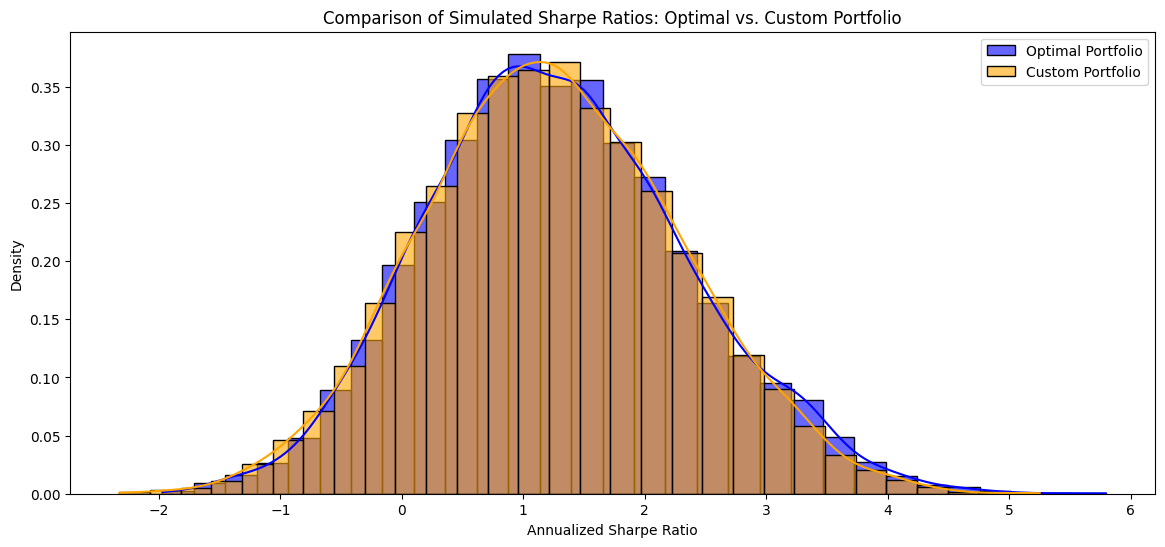


Optimal Portfolio Sharpe Ratio Simulation Stats:
count    10000.000000
mean         1.281148
std          1.080265
min         -1.970542
25%          0.536772
50%          1.229278
75%          1.988156
max          5.793743
dtype: float64

Custom Portfolio Sharpe Ratio Simulation Stats:
count    10000.000000
mean         1.239501
std          1.061686
min         -2.324785
25%          0.504393
50%          1.214264
75%          1.959809
max          5.250949
dtype: float64


In [19]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import math

# ---------------------------
# Parameters and Data Download
# ---------------------------
selected_tickers = ['NVDA', 'AAPL', 'AMZN', 'GOOGL','NFLX','^GSPC','SHOP','TSLA','MSFT']
start_date = "2013-01-01"  # Lookback period
end_date   = "2023-01-01"

# Download stock data from yfinance
data = yf.download(selected_tickers, start=start_date, end=end_date, progress=False)
if isinstance(data.columns, pd.MultiIndex):
    if "Adj Close" in data.columns.get_level_values(0):
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]
else:
    if "Adj Close" in data.columns:
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]

# Compute daily returns
stock_returns = stock_prices.pct_change().dropna()

# ---------------------------
# Fetch Fama–French 3-Factor Data via pandas_datareader
# ---------------------------
ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]
# Format the index based on pattern
example_index = ff.index[0]
if '-' in str(example_index):
    ff.index = pd.to_datetime(ff.index.astype(str), format="%Y-%m")
else:
    ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")
# Resample monthly data to daily frequency using forward fill
ff_daily = ff.resample('D').ffill()
ff_daily = ff_daily.loc[ff_daily.index >= pd.to_datetime(start_date)]
ff_daily.columns = ff_daily.columns.str.replace('-', '_')
ff_daily[['Mkt_RF', 'SMB', 'HML', 'RF']] = ff_daily[['Mkt_RF', 'SMB', 'HML', 'RF']] / 100

# ---------------------------
# Compute Multifactor Expected Returns for Each Stock
# ---------------------------
expected_returns = {}
for ticker in selected_tickers:
    df = pd.concat([stock_returns[ticker], ff_daily], axis=1).dropna()
    df.columns = ['stock_return', 'Mkt_RF', 'SMB', 'HML', 'RF']
    df['excess_return'] = df['stock_return'] - df['RF']

    X = df[['Mkt_RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    y = df['excess_return']
    model = sm.OLS(y, X).fit()

    avg_factors = ff_daily[['Mkt_RF', 'SMB', 'HML']].mean()
    expected_daily_excess = (model.params['const'] +
                             model.params['Mkt_RF'] * avg_factors['Mkt_RF'] +
                             model.params['SMB'] * avg_factors['SMB'] +
                             model.params['HML'] * avg_factors['HML'])
    annual_expected_excess = expected_daily_excess * 252
    annual_rf = ff_daily['RF'].mean() * 252
    expected_returns[ticker] = annual_rf + annual_expected_excess

# ---------------------------
# Compute Historical Covariance Matrix (Annualized)
# ---------------------------
cov_matrix = stock_returns[selected_tickers].cov() * 252

# ---------------------------
# MPT Simulation using Multifactor Expected Returns (with min weight constraint)
# ---------------------------
num_portfolios = 15000  # Number of simulated portfolios
results = np.zeros((3, num_portfolios))  # [Return, Volatility, Sharpe Ratio]
weights_record = []
multi_expected_returns = np.array([expected_returns[ticker] for ticker in selected_tickers])
risk_free_rate_annual = ff_daily['RF'].mean() * 252
n = len(selected_tickers)
min_weight = 0.05  # Minimum weight per stock

for i in range(num_portfolios):
    weights = min_weight + np.random.dirichlet(np.ones(n)) * (1 - n * min_weight)
    weights_record.append(weights)
    port_return = np.dot(weights, multi_expected_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate_annual) / port_vol

    results[0, i] = port_return
    results[1, i] = port_vol
    results[2, i] = sharpe_ratio

results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio'])
max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = results_df.iloc[max_sharpe_idx]
optimal_weights = weights_record[max_sharpe_idx]

print("\nOptimal Portfolio using Multifactor Expected Returns (MPT):")
print(max_sharpe_portfolio)
optimal_weights_df = pd.DataFrame({'Ticker': selected_tickers, 'Weight (%)': optimal_weights*100})
print("\nOptimal Weights (each >= 5%):")
print(optimal_weights_df)

# ---------------------------
# Compare with Custom Weightings
# ---------------------------
# Define your custom weightings here (ensure they sum to 1)
custom_weights = {
    'NVDA': 0.30,
    'AAPL': 0.05,
    'AMZN': 0.06,
    'GOOGL': 0.10,
    'NFLX': 0.21,
    '^GSPC': 0.10,
    'SHOP': 0.08,
    'TSLA': 0.06,
    'MSFT': 0.04
}
custom_weights_array = np.array([custom_weights[ticker] for ticker in selected_tickers])

def portfolio_performance(weights, expected_returns_array, cov_matrix, risk_free_rate):
    port_return = np.dot(weights, expected_returns_array)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_vol
    return port_return, port_vol, sharpe_ratio

custom_port_return, custom_port_vol, custom_sharpe = portfolio_performance(
    custom_weights_array, multi_expected_returns, cov_matrix, risk_free_rate_annual)

print("\nCustom Portfolio Performance:")
print(f"  Expected Return: {custom_port_return:.2%}")
print(f"  Volatility: {custom_port_vol:.2%}")
print(f"  Sharpe Ratio: {custom_sharpe:.2f}")

# ===========================================================================
# Block Bootstrap Monte Carlo Simulation for Portfolio Performance
# ===========================================================================

def block_bootstrap_daily_returns(returns_data, weights, days_to_simulate, block_size, num_simulations=1000):
    """
    Returns a 2D array of simulated portfolio daily returns using block bootstrap.
    Each row represents a simulated daily return path over 'days_to_simulate' days.
    """
    T = len(returns_data)
    returns_array = returns_data.values  # shape: (T, n_stocks)
    n_stocks = len(weights)
    daily_returns_all = np.zeros((num_simulations, days_to_simulate), dtype=np.float64)

    for sim_idx in range(num_simulations):
        path_daily_returns = []
        num_blocks = days_to_simulate // block_size
        leftover_days = days_to_simulate % block_size

        # Sample full blocks
        for _ in range(num_blocks):
            start_idx = np.random.randint(0, T - block_size)
            block = returns_array[start_idx:start_idx+block_size, :]  # shape: (block_size, n_stocks)
            for day_returns in block:
                path_daily_returns.append(np.dot(weights, day_returns))

        # Handle leftover days
        if leftover_days > 0:
            start_idx = np.random.randint(0, T - leftover_days)
            leftover_block = returns_array[start_idx:start_idx+leftover_days, :]
            for day_returns in leftover_block:
                path_daily_returns.append(np.dot(weights, day_returns))

        daily_returns_all[sim_idx, :] = path_daily_returns

    return daily_returns_all

# ---------------------------------
# Optuna Objective to Tune Block Size
# ---------------------------------
def objective(trial):
    block_size = trial.suggest_int('block_size', 5, 60)
    sim_returns = block_bootstrap_daily_returns(
        returns_data=stock_returns[selected_tickers].dropna(),
        weights=optimal_weights,
        days_to_simulate=252,
        block_size=block_size,
        num_simulations=1000
    )
    n_sims = sim_returns.shape[0]
    sharpe_ratios = np.zeros(n_sims)
    daily_rf = 0.0125 / 252  # daily risk-free rate

    for i in range(n_sims):
        path = sim_returns[i, :]
        mean_path = np.mean(path)
        std_path = np.std(path)
        excess_mean = mean_path - daily_rf
        sharpe_ratios[i] = (excess_mean / std_path) * np.sqrt(252) if std_path != 0 else -9999

    return np.mean(sharpe_ratios)

# Run Optuna to find best block size for the optimal portfolio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs=-1)
best_block_size = study.best_params['block_size']
print("\nOptimal block size from Optuna:", best_block_size)

# ---------------------------------
# Simulation Function for Sharpe Ratios
# ---------------------------------
def simulate_sharpe_ratios(weights, block_size, days_to_simulate=252, num_simulations=10000):
    sim_returns = block_bootstrap_daily_returns(
        returns_data=stock_returns[selected_tickers].dropna(),
        weights=weights,
        days_to_simulate=days_to_simulate,
        block_size=block_size,
        num_simulations=num_simulations
    )
    n_sims = sim_returns.shape[0]
    sharpe_ratios = np.zeros(n_sims)
    daily_rf = 0.0125 / 252
    for i in range(n_sims):
        path = sim_returns[i, :]
        mean_path = np.mean(path)
        std_path = np.std(path)
        excess_mean = mean_path - daily_rf
        sharpe_ratios[i] = (excess_mean / std_path) * np.sqrt(252) if std_path != 0 else -9999
    return sharpe_ratios

# Run simulations for both portfolios using the best block size
optimal_sharpes = simulate_sharpe_ratios(optimal_weights, block_size=best_block_size, num_simulations=10000)
custom_sharpes = simulate_sharpe_ratios(custom_weights_array, block_size=best_block_size, num_simulations=10000)

# ---------------------------------
# Plot Comparison of Simulated Sharpe Ratio Distributions
# ---------------------------------
plt.figure(figsize=(14,6))
sns.histplot(optimal_sharpes, color='blue', kde=True, label='Optimal Portfolio', stat="density", bins=30, alpha=0.6)
sns.histplot(custom_sharpes, color='orange', kde=True, label='Custom Portfolio', stat="density", bins=30, alpha=0.6)
plt.xlabel("Annualized Sharpe Ratio")
plt.ylabel("Density")
plt.title("Comparison of Simulated Sharpe Ratios: Optimal vs. Custom Portfolio")
plt.legend()
plt.show()

# Print summary statistics for simulation results
print("\nOptimal Portfolio Sharpe Ratio Simulation Stats:")
print(pd.Series(optimal_sharpes).describe())

print("\nCustom Portfolio Sharpe Ratio Simulation Stats:")
print(pd.Series(custom_sharpes).describe())


<ipython-input-23-2485a84d25fb>:34: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]
<ipython-input-23-2485a84d25fb>:34: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]



Optimal Portfolio using Multifactor Expected Returns (MPT):
Return          0.422664
Volatility      0.376241
Sharpe Ratio    0.740363
Name: 2632, dtype: float64

Optimal Weights (each >= 5%):
  Ticker  Weight (%)
0   NVDA   75.221824
1   AAPL    6.076394
2   AMZN    6.423178
3   META    5.918919
4  GOOGL    6.359685

Custom Portfolio Performance:
  Expected Return: 27.55%
  Volatility: 28.02%
  Sharpe Ratio: 0.47


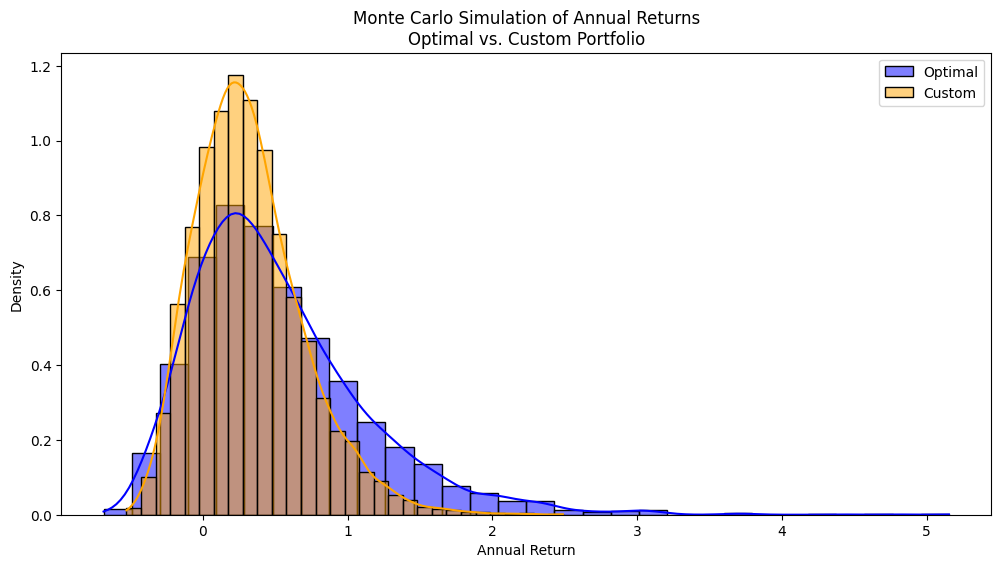

Optimal Portfolio Monte Carlo Stats:
  Mean Return   : 51.85%
  Std Dev       : 60.64%
  5th Percentile: -24.24%
  95th Percentile: 165.12%

Custom Portfolio Monte Carlo Stats:
  Mean Return   : 32.01%
  Std Dev       : 37.38%
  5th Percentile: -20.15%
  95th Percentile: 101.84%



In [23]:
import pandas as pd
import yfinance as yf
import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# Parameters and Data Download
# ---------------------------
selected_tickers = ['NVDA', 'AAPL', 'AMZN', 'META', 'GOOGL']
start_date = "2013-01-01"  # 10-year lookback period ending 2022-12-31
end_date   = "2023-01-01"

data = yf.download(selected_tickers, start=start_date, end=end_date, progress=False)
if isinstance(data.columns, pd.MultiIndex):
    if "Adj Close" in data.columns.get_level_values(0):
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]
else:
    if "Adj Close" in data.columns:
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]

# Compute daily returns
stock_returns = stock_prices.pct_change().dropna()

# ---------------------------
# Fetch Fama–French 3-Factor Data via pandas_datareader
# ---------------------------
ff = web.DataReader("F-F_Research_Data_Factors", "famafrench", start=start_date, end=end_date)[0]
example_index = ff.index[0]
if '-' in str(example_index):
    ff.index = pd.to_datetime(ff.index.astype(str), format="%Y-%m")
else:
    ff.index = pd.to_datetime(ff.index.astype(str), format="%Y%m")

ff_daily = ff.resample('D').ffill()
ff_daily = ff_daily.loc[ff_daily.index >= pd.to_datetime(start_date)]
ff_daily.columns = ff_daily.columns.str.replace('-', '_')
ff_daily[['Mkt_RF', 'SMB', 'HML', 'RF']] = ff_daily[['Mkt_RF', 'SMB', 'HML', 'RF']] / 100

# ---------------------------
# Compute Multifactor Expected Returns for Each Stock
# ---------------------------
expected_returns = {}
for ticker in selected_tickers:
    df = pd.concat([stock_returns[ticker], ff_daily], axis=1).dropna()
    df.columns = ['stock_return', 'Mkt_RF', 'SMB', 'HML', 'RF']
    df['excess_return'] = df['stock_return'] - df['RF']

    X = df[['Mkt_RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    y = df['excess_return']
    model = sm.OLS(y, X).fit()

    avg_factors = ff_daily[['Mkt_RF', 'SMB', 'HML']].mean()
    expected_daily_excess = (model.params['const'] +
                             model.params['Mkt_RF'] * avg_factors['Mkt_RF'] +
                             model.params['SMB'] * avg_factors['SMB'] +
                             model.params['HML'] * avg_factors['HML'])
    annual_expected_excess = expected_daily_excess * 252
    annual_rf = ff_daily['RF'].mean() * 252
    expected_returns[ticker] = annual_rf + annual_expected_excess

# ---------------------------
# Compute Historical Covariance Matrix (Annualized)
# ---------------------------
cov_matrix = stock_returns[selected_tickers].cov() * 252

# ---------------------------
# MPT Simulation using Multifactor Expected Returns (with min weight constraint)
# ---------------------------
num_portfolios = 15000
results = np.zeros((3, num_portfolios))  # [Return, Volatility, Sharpe Ratio]
weights_record = []
multi_expected_returns = np.array([expected_returns[ticker] for ticker in selected_tickers])
risk_free_rate_annual = ff_daily['RF'].mean() * 252

n = len(selected_tickers)
min_weight = 0.05

for i in range(num_portfolios):
    weights = min_weight + np.random.dirichlet(np.ones(n)) * (1 - n * min_weight)
    weights_record.append(weights)

    port_return = np.dot(weights, multi_expected_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate_annual) / port_vol

    results[0, i] = port_return
    results[1, i] = port_vol
    results[2, i] = sharpe_ratio

results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio'])
max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = results_df.iloc[max_sharpe_idx]
optimal_weights = weights_record[max_sharpe_idx]

print("\nOptimal Portfolio using Multifactor Expected Returns (MPT):")
print(max_sharpe_portfolio)
optimal_weights_df = pd.DataFrame({'Ticker': selected_tickers, 'Weight (%)': optimal_weights*100})
print("\nOptimal Weights (each >= 5%):")
print(optimal_weights_df)

# ---------------------------
# Compare with Custom Weightings
# ---------------------------
custom_weights = {
    'NVDA': 0.20,
    'AAPL': 0.10,
    'AMZN': 0.23,
    'META': 0.28,
    'GOOGL': 0.19
}
custom_weights_array = np.array([custom_weights[ticker] for ticker in selected_tickers])

def portfolio_performance(weights, expected_returns_array, cov_matrix, risk_free_rate):
    port_return = np.dot(weights, expected_returns_array)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - risk_free_rate) / port_vol
    return port_return, port_vol, sharpe_ratio

custom_port_return, custom_port_vol, custom_sharpe = portfolio_performance(
    custom_weights_array, multi_expected_returns, cov_matrix, risk_free_rate_annual)

print("\nCustom Portfolio Performance:")
print(f"  Expected Return: {custom_port_return:.2%}")
print(f"  Volatility: {custom_port_vol:.2%}")
print(f"  Sharpe Ratio: {custom_sharpe:.2f}")

# ===========================================================================
# Monte Carlo Simulation for BOTH Optimal & Custom Portfolios
# ===========================================================================

def monte_carlo_portfolio_sim(returns_df, weights, days=252, num_sim=5000):
    """
    Simple daily resampling (bootstrap) to simulate annual returns.
    Returns an array of annual returns from each simulation.
    """
    # Convert DataFrame to NumPy array for faster operations
    returns_array = returns_df.values  # shape: (T, n_stocks)
    T, n_stocks = returns_array.shape
    w = np.array(weights)

    annual_returns = np.zeros(num_sim)

    for i in range(num_sim):
        # Randomly sample 'days' from historical daily returns (with replacement)
        idx = np.random.randint(0, T, size=days)
        sample = returns_array[idx, :]  # shape: (days, n_stocks)

        # Compute daily portfolio returns
        daily_port_returns = np.dot(sample, w)

        # Compute annual return for this simulation
        # e.g., compounding the daily returns
        annual_return = (1 + daily_port_returns).prod() - 1
        annual_returns[i] = annual_return

    return annual_returns

# 1) Simulate annual returns for the Optimal portfolio
optimal_mc_returns = monte_carlo_portfolio_sim(stock_returns[selected_tickers].dropna(),
                                               optimal_weights,
                                               days=252,
                                               num_sim=5000)

# 2) Simulate annual returns for the Custom portfolio
custom_mc_returns = monte_carlo_portfolio_sim(stock_returns[selected_tickers].dropna(),
                                              custom_weights_array,
                                              days=252,
                                              num_sim=5000)

# Plot Histograms
plt.figure(figsize=(12,6))
sns.histplot(optimal_mc_returns, color='blue', kde=True, label='Optimal', stat="density", bins=30, alpha=0.5)
sns.histplot(custom_mc_returns, color='orange', kde=True, label='Custom', stat="density", bins=30, alpha=0.5)
plt.title("Monte Carlo Simulation of Annual Returns\nOptimal vs. Custom Portfolio")
plt.xlabel("Annual Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# Print summary stats
def print_summary_stats(name, returns_array):
    mean_ret = returns_array.mean()
    std_ret  = returns_array.std()
    pct_5    = np.percentile(returns_array, 5)
    pct_95   = np.percentile(returns_array, 95)
    print(f"{name} Portfolio Monte Carlo Stats:")
    print(f"  Mean Return   : {mean_ret:.2%}")
    print(f"  Std Dev       : {std_ret:.2%}")
    print(f"  5th Percentile: {pct_5:.2%}")
    print(f"  95th Percentile: {pct_95:.2%}\n")

print_summary_stats("Optimal", optimal_mc_returns)
print_summary_stats("Custom", custom_mc_returns)


In [59]:
import pandas as pd
import yfinance as yf
import numpy as np
import pygal
from pygal.style import Style
from IPython.display import SVG, display
import datetime


selected_tickers = ['NVDA', 'AAPL', 'AMZN', 'GOOGL', 'NFLX', '^GSPC', 'SHOP', 'TSLA', 'MSFT','META','^TNX']
start_date = "2013-01-01"
end_date   = "2025-02-01"

data = yf.download(selected_tickers, start=start_date, end=end_date, progress=False)


if isinstance(data.columns, pd.MultiIndex):
    if "Adj Close" in data.columns.get_level_values(0):
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]
else:
    if "Adj Close" in data.columns:
        stock_prices = data["Adj Close"]
    else:
        stock_prices = data["Close"]


stock_returns_daily = stock_prices.pct_change().dropna()


custom_weights_1 = {
    'META': 0.28,
    'AMZN': 0.24,
    'NVDA': 0.20,
    'GOOGL': 0.19,
    'AAPL': 0.09,
    'NFLX': 0.00,
    '^GSPC': 0.00,
    'SHOP': 0.00,
    'TSLA': 0.00,
    'MSFT': 0.00,
    '^TNX': 0.00
}

custom_weights_2 = {
    'NVDA': 0.29,
    'AAPL': 0.05,
    'AMZN': 0.06,
    'GOOGL': 0.05,
    'NFLX': 0.21,
    '^GSPC': 0.10,
    'SHOP': 0.08,
    'TSLA': 0.06,
    'MSFT': 0.04,
    '^TNX': 0.06,
    'META': 0.00
}

custom_weights_array_1 = np.array([custom_weights_1[t] for t in stock_returns_daily.columns])
custom_weights_array_2 = np.array([custom_weights_2[t] for t in stock_returns_daily.columns])


def portfolio_returns_daily(returns_df, weights):
    return (returns_df * weights).sum(axis=1)


custom1_daily = portfolio_returns_daily(stock_returns_daily, custom_weights_array_1)
custom2_daily = portfolio_returns_daily(stock_returns_daily, custom_weights_array_2)
sp500_daily   = stock_returns_daily['^GSPC']


custom1_cum = (1 + custom1_daily).cumprod()
custom2_cum = (1 + custom2_daily).cumprod()
sp500_cum   = (1 + sp500_daily).cumprod()


all_values = pd.concat([custom1_cum, custom2_cum, sp500_cum])
ymin, ymax = all_values.min(), all_values.max()


def series_to_datatuples(series):
    return [(idx.to_pydatetime().date(), float(val)) for idx, val in series.items()]

custom1_data = series_to_datatuples(custom1_cum)
custom2_data = series_to_datatuples(custom2_cum)
sp500_data   = series_to_datatuples(sp500_cum)


custom_style = Style(
    background='white',
    plot_background='white',
    foreground='#000000',
    legend_font_size=12,
    label_font_size=10,
    major_label_font_size=10
)

line_chart = pygal.DateLine(
    style=custom_style,
    width=1000,
    height=500,
    x_label_rotation=35,
    show_legend=True,
    title="Growth of $1: Personal Fund vs. Virtual Fund vs. S&P 500 (Daily)",
    show_dots=False,
    interpolate='cubic'
)

line_chart.xrange = (datetime.date(2013, 1, 1), datetime.date(2025, 3, 1))


line_chart.add("Virtual Fund", custom1_data, color="#E74C3C", stroke_style={'width': 3})
line_chart.add("Personal Fund", custom2_data, color="#2ECC71", stroke_style={'width': 3})
line_chart.add("S&P 500", sp500_data, color="#3498DB", stroke_style={'width': 3})


purchase_date = datetime.date(2023, 1, 9)
purchase_baseline_color = "#0d1b2a"

vertical_line_data = [
    (purchase_date, float(ymin)),
    (purchase_date, float(ymax))
]

line_chart.add(
    "Purchase",
    vertical_line_data,
    show_legend=False,
    allow_interruptions=False,
    color=purchase_baseline_color,
    stroke_style={'width': 4, 'dasharray': '3,3'}
)

chart_filename = "growth_of_1_pygal_daily.svg"
line_chart.render_to_file(chart_filename)
display(SVG(chart_filename))
print("Chart saved as:", chart_filename)


def annualized_return(returns_daily, freq=252):
    return returns_daily.mean() * freq

def sharpe_ratio(returns_daily, risk_free=0.0, freq=252):
    avg_d = returns_daily.mean()
    std_d = returns_daily.std()
    if std_d == 0:
        return np.nan
    return (avg_d - risk_free) / std_d * np.sqrt(freq)

def sortino_ratio(returns_daily, risk_free=0.0, freq=252):
    avg_d = returns_daily.mean()
    neg_returns = returns_daily[returns_daily < 0]
    downside_std = neg_returns.std()
    if downside_std == 0:
        return np.nan
    return (avg_d - risk_free) / downside_std * np.sqrt(freq)

def max_drawdown(cum_returns):
    dd_series = cum_returns / cum_returns.cummax() - 1
    return dd_series.min()


pf_sharpe    = sharpe_ratio(custom1_daily)
pf_sortino   = sortino_ratio(custom1_daily)
pf_max_dd    = max_drawdown(custom1_cum)


vf_sharpe    = sharpe_ratio(custom2_daily)
vf_sortino   = sortino_ratio(custom2_daily)
vf_max_dd    = max_drawdown(custom2_cum)


sp_sharpe    = sharpe_ratio(sp500_daily)
sp_sortino   = sortino_ratio(sp500_daily)
sp_max_dd    = max_drawdown(sp500_cum)

print("\nRisk Metrics (annualized using daily freq=252)\n")
print("-----------------------------------------------------------------")
print("                 Sharpe    Sortino   Max Drawdown")
print("                 Ratio     Ratio     ( % )")
print("-----------------------------------------------------------------")

print(f"Virtual"
      f"     {pf_sharpe:7.2f}"
      f"     {pf_sortino:7.2f}"
      f"     {pf_max_dd*100:7.2f}")

print(f"Personal"
      f"     {vf_sharpe:7.2f}"
      f"     {vf_sortino:7.2f}"
      f"     {vf_max_dd*100:7.2f}")

print(f"S&P 500"
      f"     {sp_sharpe:7.2f}"
      f"     {sp_sortino:7.2f}"
      f"     {sp_max_dd*100:7.2f}")

print("-----------------------------------------------------------------")


Output hidden; open in https://colab.research.google.com to view.